In [1]:
from fastai.vision.all import *
import cv2
import skimage as sm
import skimage.io
import tifffile
path = Path('/notebooks/DL_paper') # replace with your own path

In [2]:
# Training

# loads txt file with names of files in validation dataset
valid_fnames = (path/'models/tissueModel/validTissue.txt').read_text().split('\n')

# Names of class
codes = np.loadtxt(path/'models/tissueModel/codesTissue.txt', dtype=str)

# function to get mask using name of image
get_msk = lambda o: path/f'dat_tissue/train_masks'/f'mask{o.stem.split("g")[1]}{o.suffix}'

# Make the dataloader 
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                    get_items=get_image_files,
                    splitter=FileSplitter(path/'models/tissueModel/validTissue.txt'),
                    get_y=get_msk,
                    batch_tfms=[*aug_transforms(), # augmentations
                    Normalize.from_stats(*imagenet_stats)]) 
dls = camvid.dataloaders(path/f'dat_tissue/train_images', bs=4) # bs is the batch size
dls.vocab = codes
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

# define metric to assess model performance 
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean() 
opt = ranger

# Makes the unet model from a resnet101 model
learn = unet_learner(dls, resnet101, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt).to_fp16()

# Load training model if one avalable 
# learn.load(f'UNetTissue')


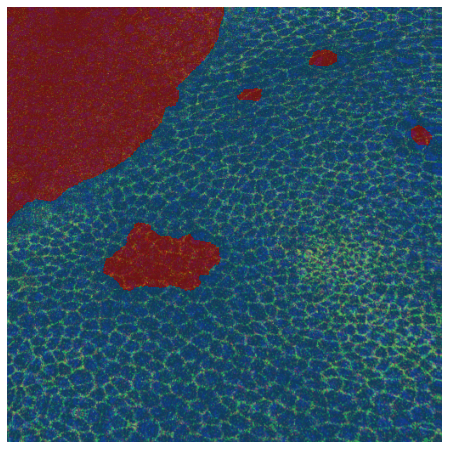

In [3]:
# displays image and overlays mask after augmentations have been applied
dls.show_batch(max_n=1, figsize=(8,8))

SuggestedLRs(valley=tensor(2.0893e-05))

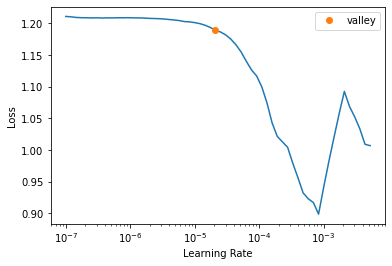

In [4]:
# Find learning rate
learn.lr_find()

In [4]:
# Train model 
learn.fine_tune(1, base_lr=1e-4)
learn.save(f'UNetTissue')

epoch,train_loss,valid_loss,acc_camvid,time
0,0.092618,0.094893,0.958846,33:31


epoch,train_loss,valid_loss,acc_camvid,time
0,0.053601,0.094933,0.959914,32:35


Path('models/UNetTissue.pth')

SuggestedLRs(valley=tensor(7.5858e-05))

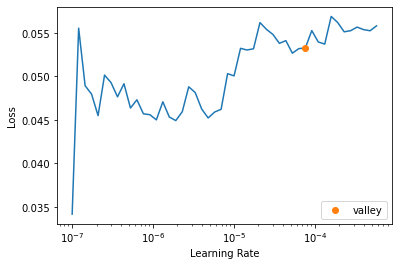

In [5]:
learn.unfreeze()
learn.lr_find()

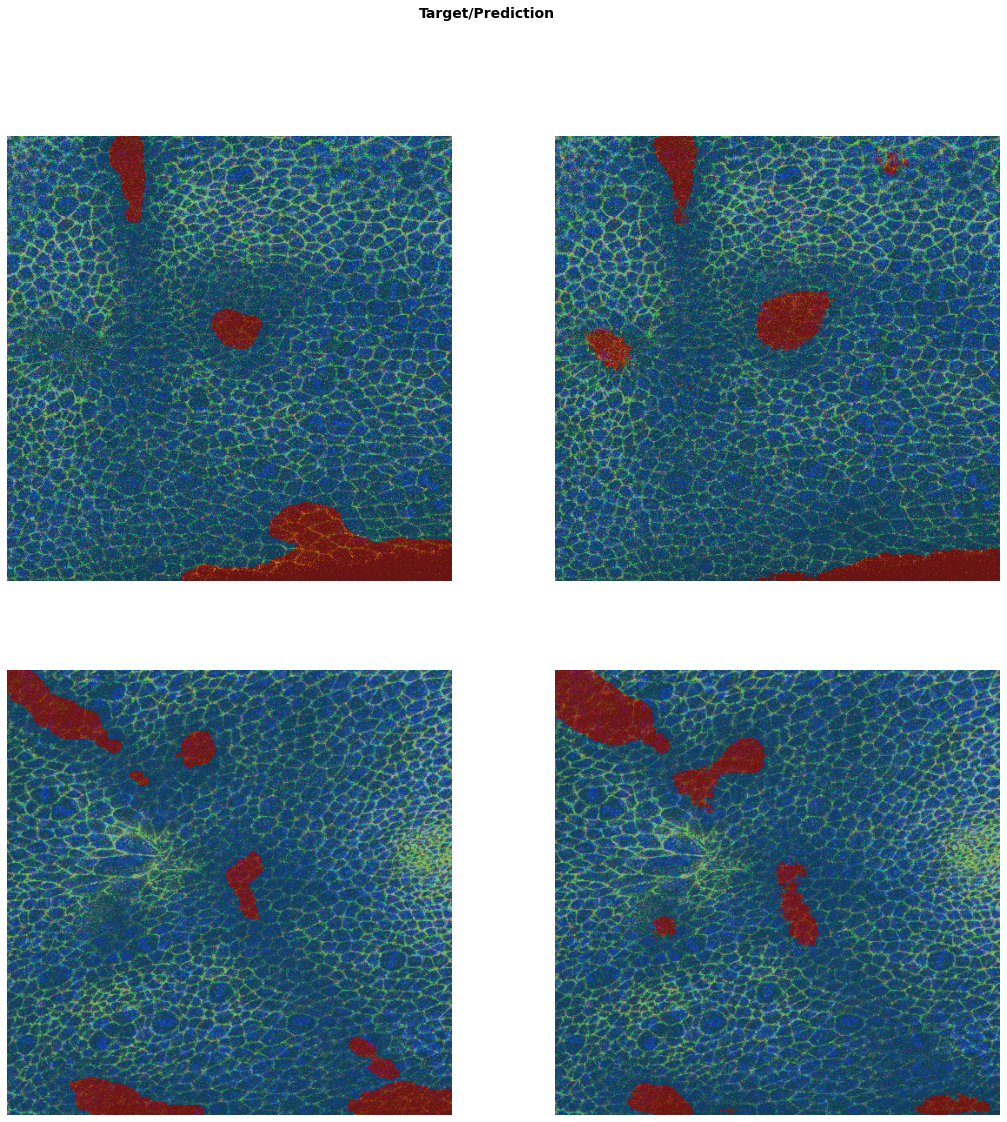

In [6]:
# Shows the ground truth with the model prediciton
learn.show_results(max_n=2, figsize=(18,18))

In [5]:
# find number of parameters in model
model = learn.model

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

378
361012125
